In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.api import qqplot
import statsmodels.api as sm
import itertools

## **Time series data**

In [2]:
ticker = "SUZLON.NS"

end_date = datetime.today()
start_date = end_date - timedelta(days=10*256)

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print()
print(data)

[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker      SUZLON.NS  SUZLON.NS  SUZLON.NS  SUZLON.NS  SUZLON.NS
Date                                                             
2018-07-23   6.840694   6.886604   6.473408   6.473408   30889217
2018-07-24   7.712997   7.896640   6.748872   6.794783   99429478
2018-07-25   7.391622   7.942550   7.299801   7.758908   87474233
2018-07-26   7.162068   7.529354   7.070247   7.437533  105574671
2018-07-27   7.070247   7.345711   7.024336   7.253890   24277154
...               ...        ...        ...        ...        ...
2025-07-17  66.260002  67.139999  66.050003  67.099998   31477927
2025-07-18  65.059998  66.589996  64.769997  66.260002   37155281
2025-07-21  66.419998  66.500000  65.000000  65.239998   35813725
2025-07-22  66.580002  66.779999  65.699997  66.680000   35735857
2025-07-23  65.980003  66.440002  65.519997  66.099998   32844030

[1728 rows x 5 columns]


In [3]:
print(data.shape)

(1728, 5)


In [4]:
print(data['Close'].loc['2025-07-14'])

Ticker
SUZLON.NS    65.440002
Name: 2025-07-14 00:00:00, dtype: float64


## **Line plot**

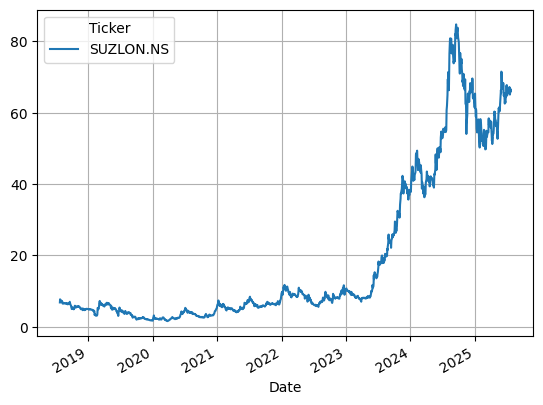

In [5]:
data['Close'].plot()
plt.grid()
plt.show()

## **Statistics**

In [6]:
pd.options.display.float_format = '{:.2f}'.format
data['Close'].describe()

Ticker,SUZLON.NS
count,1728.00
mean,18.99
std,22.40
min,1.61
25%,4.82
50%,7.12
75%,31.32
max,84.70


## **Histogram & density plots**

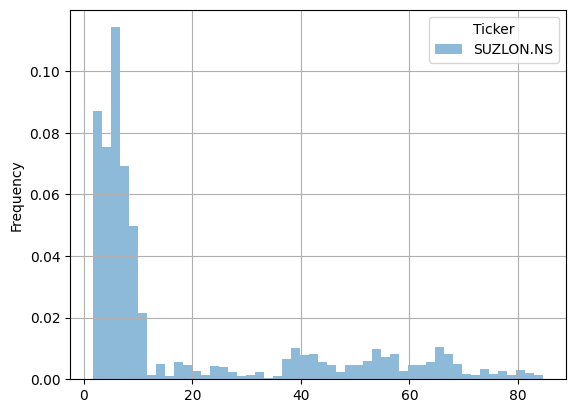

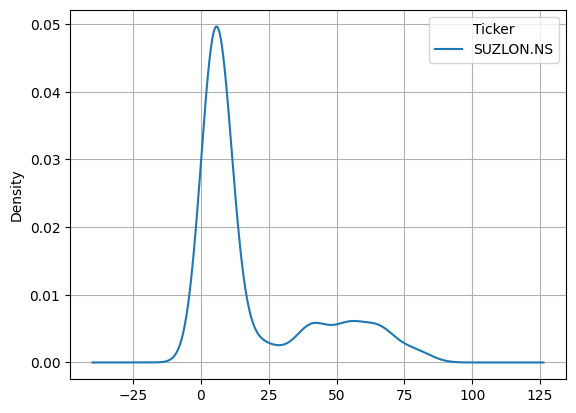

In [7]:
# Histogram
data['Close'].plot(kind='hist', bins=50, density=True, alpha=0.5)
plt.grid()
plt.show()

# Density Plot
data['Close'].plot(kind='kde')
plt.grid()
plt.show()

## **Box plot**

In [8]:
X = data['Close'].copy()
X['Year'] = X.index.year
display(X.head())

Ticker,SUZLON.NS,Year
Date,,
2018-07-23,6.84,2018
2018-07-24,7.71,2018
2018-07-25,7.39,2018
2018-07-26,7.16,2018
2018-07-27,7.07,2018


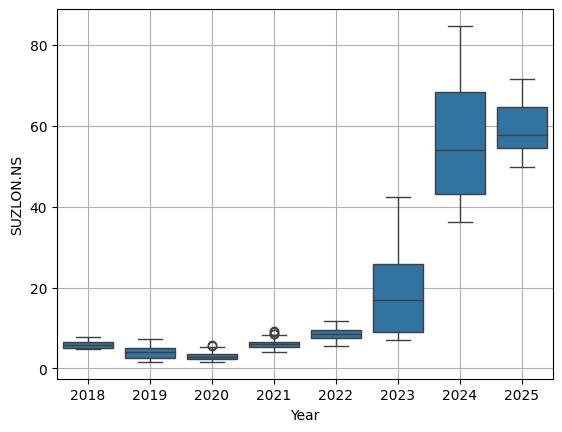

In [9]:
sns.boxplot(x='Year', y='SUZLON.NS', data=X)
plt.grid()
plt.show()

In [10]:
data['Close'].isnull().sum()

,0
Ticker,
SUZLON.NS,0


## **Log transformation**

In [11]:
data_log = np.log(data['Close'])
print(data['Close'].head())
print()
print((data_log).head())

Ticker      SUZLON.NS
Date                 
2018-07-23       6.84
2018-07-24       7.71
2018-07-25       7.39
2018-07-26       7.16
2018-07-27       7.07

Ticker      SUZLON.NS
Date                 
2018-07-23       1.92
2018-07-24       2.04
2018-07-25       2.00
2018-07-26       1.97
2018-07-27       1.96


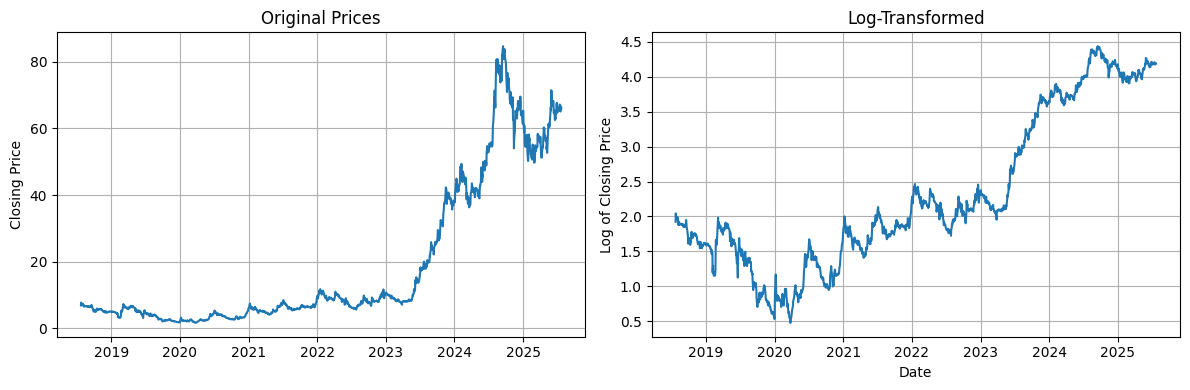

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data['Close'])
axes[0].set_title('Original Prices')
axes[0].set_ylabel('Closing Price')
axes[0].grid(True)

axes[1].plot(data_log)
axes[1].set_title('Log-Transformed')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log of Closing Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

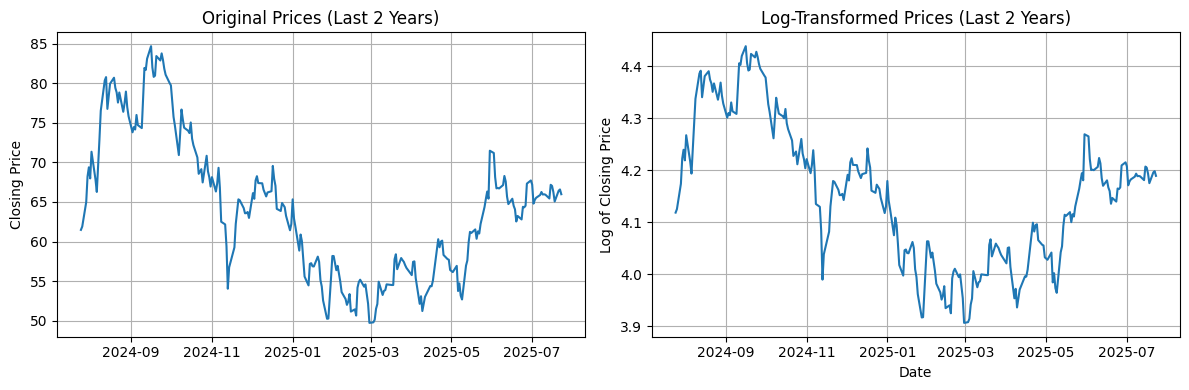

In [13]:
end_date = datetime.today()
start_date_2_years = end_date - timedelta(days=1*365)

data_2_years = data[data.index >= start_date_2_years]
data_log_2_years = data_log[data_log.index >= start_date_2_years]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data_2_years['Close'])
axes[0].set_title('Original Prices (Last 2 Years)')
axes[0].set_ylabel('Closing Price')
axes[0].grid(True)

axes[1].plot(data_log_2_years)
axes[1].set_title('Log-Transformed Prices (Last 2 Years)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log of Closing Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## **50-day moving average**

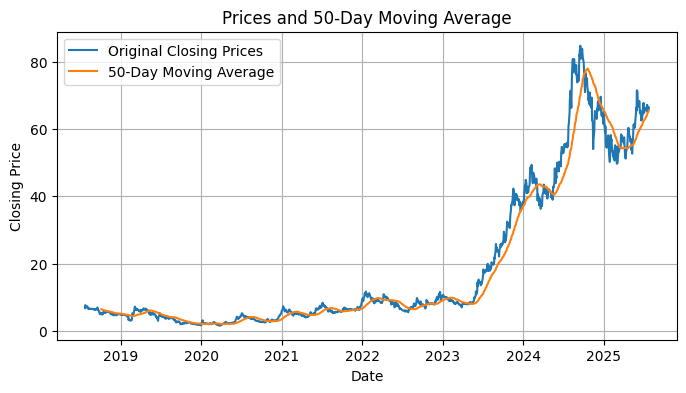

In [14]:
data_ma_20 = data['Close'].rolling(window=50).mean()

plt.figure(figsize=(8, 4))
plt.plot(data['Close'], label='Original Closing Prices')
plt.plot(data_ma_20, label='50-Day Moving Average')
plt.title('Prices and 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(data_ma_20)

Ticker      SUZLON.NS
Date                 
2018-07-23        NaN
2018-07-24        NaN
2018-07-25        NaN
2018-07-26        NaN
2018-07-27        NaN
...               ...
2025-07-17      64.62
2025-07-18      64.87
2025-07-21      65.06
2025-07-22      65.24
2025-07-23      65.36

[1728 rows x 1 columns]


## **Persistence algorithm**

predict=7.235526 <-> actual=7.345711
predict=7.336529 <-> actual=7.162068
predict=7.226343 <-> actual=7.070247
predict=7.162068 <-> actual=7.299801
predict=7.189615 <-> actual=7.253890
predict=7.226343 <-> actual=6.702961
predict=7.097793 <-> actual=6.565229
predict=6.978426 <-> actual=6.519319
predict=6.868240 <-> actual=6.840694
predict=6.776419 <-> actual=6.748872
predict=6.675415 <-> actual=6.565229
predict=6.647869 <-> actual=6.565229
predict=6.647869 <-> actual=6.611140
predict=6.666233 <-> actual=6.657051
predict=6.629504 <-> actual=6.611140
predict=6.601958 <-> actual=6.657051
predict=6.620322 <-> actual=6.565229
predict=6.620322 <-> actual=6.565229
predict=6.611140 <-> actual=6.519319
predict=6.583594 <-> actual=6.565229
predict=6.574411 <-> actual=6.611140
predict=6.565229 <-> actual=6.473408
predict=6.546865 <-> actual=6.565229
predict=6.546865 <-> actual=6.565229
predict=6.556047 <-> actual=6.335676
predict=6.510136 <-> actual=6.335676
predict=6.455044 <-> actual=6.335676
p

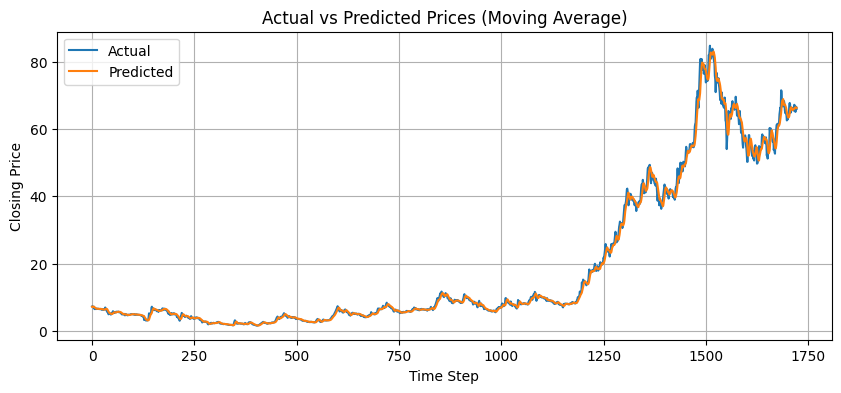

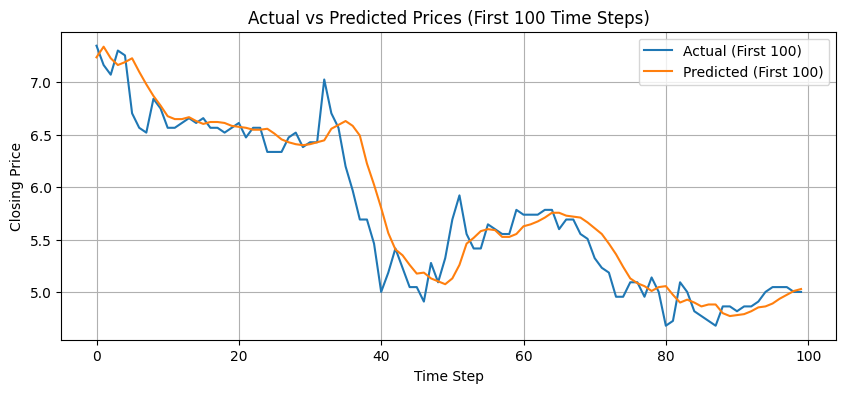

In [16]:
X = data['Close'].values
window = 5
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # Ensure obs is a scalar before casting to float
    print('predict=%.6f <-> actual=%.6f' % (float(yhat), float(obs) if np.ndim(obs) == 0 else float(obs[0])))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


plt.figure(figsize=(10, 4))
plt.plot(range(len(test)), test, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.title('Actual vs Predicted Prices (Moving Average)')
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(range(100), test[:100], label='Actual (First 100)')
plt.plot(range(100), predictions[:100], label='Predicted (First 100)')
plt.title('Actual vs Predicted Prices (First 100 Time Steps)')
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

## **Lagged dataset**

In [17]:
values = data['Close'].copy()
dataframe = pd.concat([values.shift(1), values.shift(2), values.shift(3), values], axis=1)
dataframe.columns = ['t', 't+1', 't+2', 't+3']
dataframe.head(5)

,t,t+1,t+2,t+3
Date,,,,
2018-07-23,NaN,NaN,NaN,6.84
2018-07-24,6.84,NaN,NaN,7.71
2018-07-25,7.71,6.84,NaN,7.39
2018-07-26,7.39,7.71,6.84,7.16
2018-07-27,7.16,7.39,7.71,7.07


In [18]:
dataframe.tail()

,t,t+1,t+2,t+3
Date,,,,
2025-07-17,67.03,67.17,65.44,66.26
2025-07-18,66.26,67.03,67.17,65.06
2025-07-21,65.06,66.26,67.03,66.42
2025-07-22,66.42,65.06,66.26,66.58
2025-07-23,66.58,66.42,65.06,65.98


In [19]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
Xtrain, ytrain = train[:,0], train[:,1]
Xtest, ytest = test[:,0], test[:,1]
print(Xtrain.shape, Xtest.shape)

(1381,) (346,)


In [20]:
def model_persistence(x):
    return x
predictions = list()
for x in Xtest:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(ytest, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.665


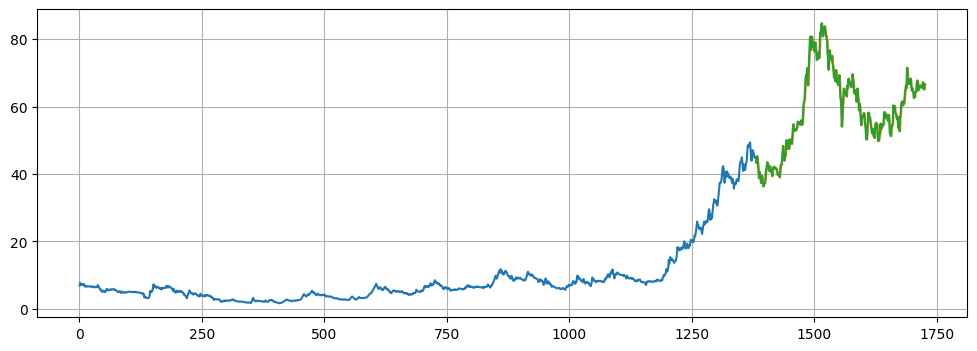

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(ytrain)
plt.plot([None for i in ytrain] + [x for x in ytest])
plt.plot([None for i in ytrain] + [x for x in predictions])
plt.grid()
plt.show()

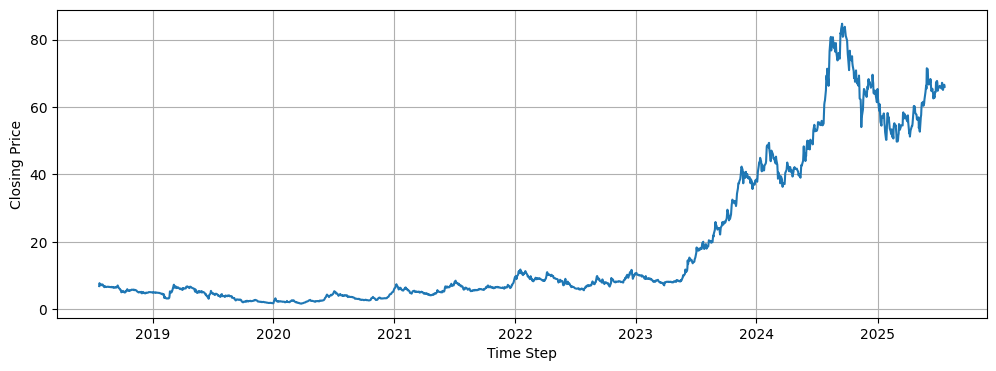

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(data['Close'])[:100]
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.grid()
plt.show()

## **Auto correlation**

In [23]:
X = np.log(data['Close']).diff().dropna()
df = pd.concat([X.shift(1), X.shift(2), X], axis=1)
df.columns = ['t-1', 't-2', 't']
df.corr()

,t-1,t-2,t
t-1,1.00,0.19,0.19
t-2,0.19,1.00,-0.00
t,0.19,-0.00,1.00


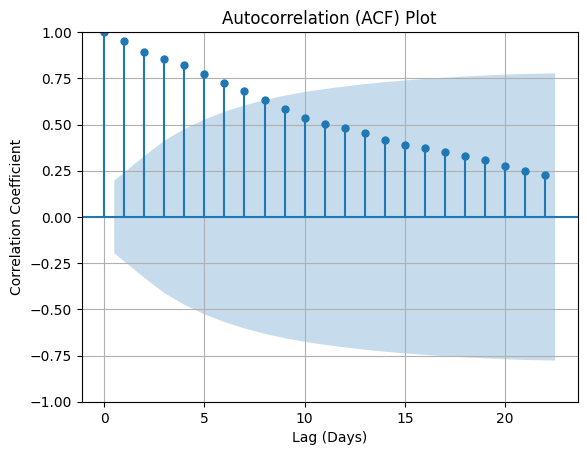

In [24]:
plot_acf(data['Close'][:100], lags=22, alpha=0.05, title='Autocorrelation (ACF) Plot')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

## **Stationarity Test: ADF**

In [25]:
result = adfuller(data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.439990
p-value: 0.982930
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## **Plot-LogDifferenced series**

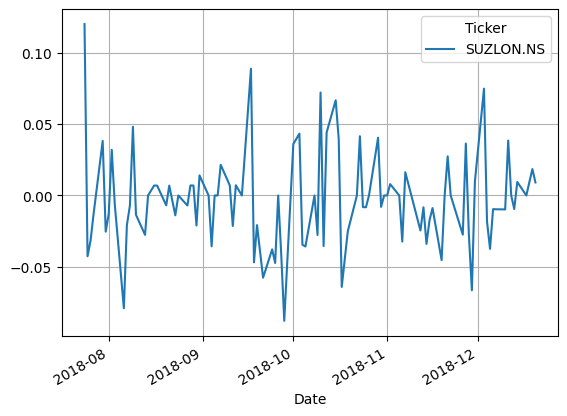

In [26]:
X[:100].plot()
plt.grid()
plt.show()

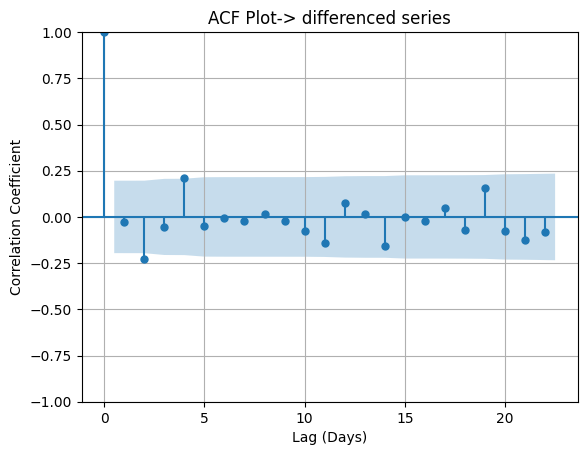

In [27]:
plot_acf(X[:100], lags=22, title='ACF Plot-> differenced series')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

In [28]:
result = adfuller(np.log(data['Close']).diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.272267
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## **Persistence model**

Test RMSE: 0.021272594553832156


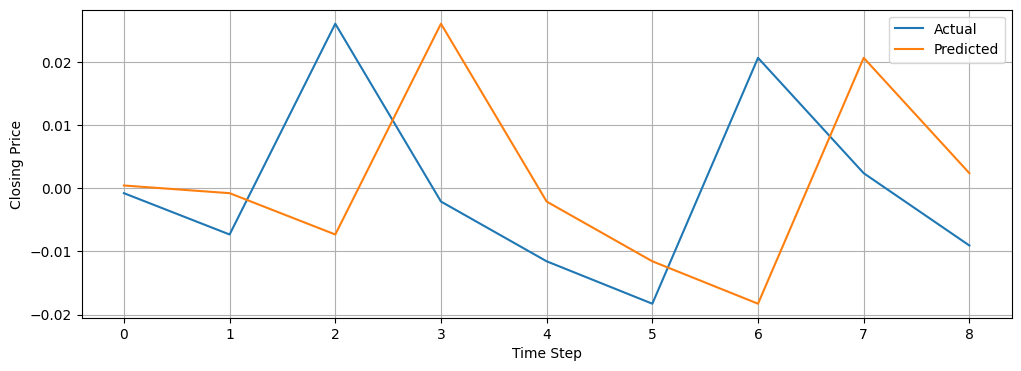

In [29]:
Z = X.values
train, test = Z[0:len(Z)-10], Z[len(Z)-10:]
Xtrain, ytrain = train[:-1], train[1:]
Xtest, ytest = test[:-1], test[1:]

def model_persistence(z):
    return z

# walk-forward validation
predictions = list()
for z in Xtest:
    yhat = model_persistence(z)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(ytest, predictions))
print('Test RMSE:', rmse)

plt.figure(figsize=(12, 4))
plt.plot(ytest)
plt.plot(predictions)
plt.legend(['Actual', 'Predicted'])
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.grid()
plt.show()

## **AR Model**

Lag: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Coefficients: [ 0.00115707  0.20493499 -0.03153877 -0.00251353 -0.01911076 -0.02609755
  0.03479456 -0.03278418 -0.00737014 -0.00896863  0.07316381 -0.00650633
 -0.07609103  0.04595776  0.02137641 -0.01824948]
predict=-0.003048 <=> actual=0.000455
predict=0.005885 <=> actual=-0.000758
predict=0.002983 <=> actual=-0.007308
predict=-0.002295 <=> actual=0.026093
predict=-0.000345 <=> actual=-0.002086
predict=0.003168 <=> actual=-0.011554
predict=0.003597 <=> actual=-0.018277
predict=-0.000099 <=> actual=0.020688
predict=0.000841 <=> actual=0.002406
predict=0.001288 <=> actual=-0.009053
Test RMSE: 0.015


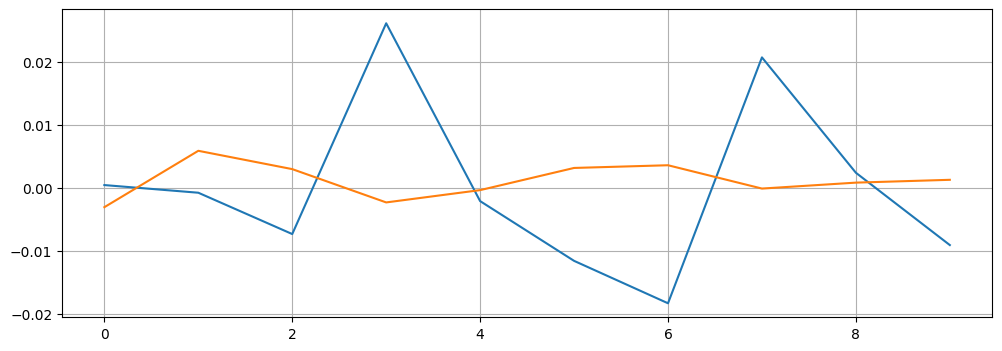

In [30]:
model = AutoReg(train, lags=15)
model_fit = model.fit()
print('Lag: %s' % model_fit.ar_lags)
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predict=%f <=> actual=%f' % (predictions[i], test[i].item()))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(12, 4))
plt.plot(test)
plt.plot(predictions)
plt.grid()
plt.show()

# **AR - Residual Error**

In [31]:
X = np.log(data['Close']).diff().dropna()
df = pd.concat([X.shift(1), X.shift(2), X], axis=1)
df.columns = ['t-1', 't-2', 't']
df.dropna(inplace=True)
X = df.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

## **Persistence model on training set**

In [32]:
train_pred = [x for x in X_train]
train_resid = [y_train[i]-train_pred[i] for i in range(len(train_pred))]
train_resid = np.array(train_resid)

## **AR Model training set**

In [33]:
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
window = int(model_fit.ar_lags[0])
coef = model_fit.params
print('Lags used: %s' % model_fit.ar_lags)
print('Coefficients: %s' % coef)

Lags used: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Coefficients: [-1.09129811e-05 -7.15014147e-01 -7.04830304e-01 -6.53193060e-01
 -6.20213377e-01 -5.95096802e-01 -4.94136019e-01 -4.87767155e-01
 -4.24234559e-01 -4.00428484e-01 -2.68018625e-01 -2.27804563e-01
 -2.64044859e-01 -1.52142344e-01 -8.22229052e-02 -5.14492376e-02]


## **Back test- walk forward over time steps in test**

predicted error=0.031497 <-> actual error=0.048892
predicted error=-0.034969 <-> actual error=-0.077134
predicted error=0.055141 <-> actual error=0.067580
predicted error=-0.048332 <-> actual error=0.013229
predicted error=-0.009470 <-> actual error=0.015863
predicted error=-0.011353 <-> actual error=0.000079
predicted error=-0.000067 <-> actual error=-0.098317
predicted error=0.070287 <-> actual error=0.079201
predicted error=-0.056640 <-> actual error=-0.030001
predicted error=0.021440 <-> actual error=0.049620
predicted error=-0.035490 <-> actual error=-0.095402
predicted error=0.068203 <-> actual error=0.035587
predicted error=-0.025456 <-> actual error=0.030733
predicted error=-0.021985 <-> actual error=0.015182
predicted error=-0.010867 <-> actual error=-0.013846
predicted error=0.009889 <-> actual error=-0.050322
predicted error=0.035970 <-> actual error=0.025836
predicted error=-0.018484 <-> actual error=0.008056
predicted error=-0.005771 <-> actual error=-0.043757
predicted er

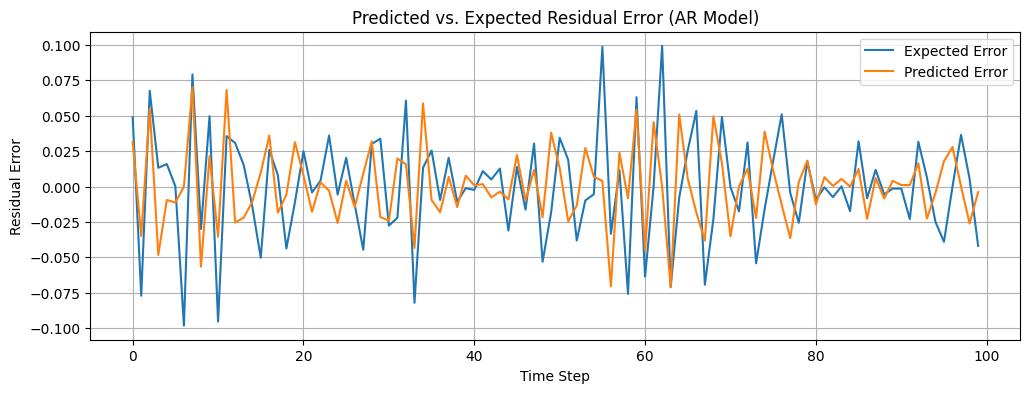

In [34]:
history = train_resid[len(train_resid)-window:]
predictions = list()
expected_error = list()

for t in range(len(y_test)):
    yhat = X_test[t]
    error = y_test[t] - yhat
    expected_error.append(error)

    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * history[window - 1 - d]

    predictions.append(pred_error)

    history = np.append(history, error)
    history = history[1:]
    print('predicted error=%f <-> actual error=%f' % (pred_error, error))

plt.figure(figsize=(12, 4))
plt.plot(expected_error[:100], label='Expected Error')
plt.plot(predictions[:100], label='Predicted Error')
plt.title('Predicted vs. Expected Residual Error (AR Model)')
plt.xlabel('Time Step')
plt.ylabel('Residual Error')
plt.legend()
plt.grid()
plt.show()

## **Predictions with Model of Residuals**

predicted=0.000726, expected=0.018121
predicted=0.011393, expected=-0.030772
predicted=0.033923, expected=0.046362
predicted=-0.082778, expected=-0.021218
predicted=-0.059779, expected=-0.034447
predicted=-0.061742, expected=-0.050310
predicted=0.047861, expected=-0.050388
predicted=0.039015, expected=0.047928
predicted=-0.057912, expected=-0.031272
predicted=-0.029452, expected=-0.001271
predicted=0.009020, expected=-0.050892
predicted=0.077126, expected=0.044510
predicted=-0.047266, expected=0.008923
predicted=-0.058978, expected=-0.021810
predicted=-0.034013, expected=-0.036992
predicted=0.037065, expected=-0.023146
predicted=0.037309, expected=0.027176
predicted=-0.025200, expected=0.001340
predicted=0.031271, expected=-0.006716
predicted=0.079448, expected=0.037041
predicted=0.031190, expected=0.048172
predicted=0.009596, expected=0.023243
predicted=0.026241, expected=0.027432
predicted=-0.015720, expected=0.023257
predicted=-0.032747, expected=-0.012724
predicted=-0.023259, expec

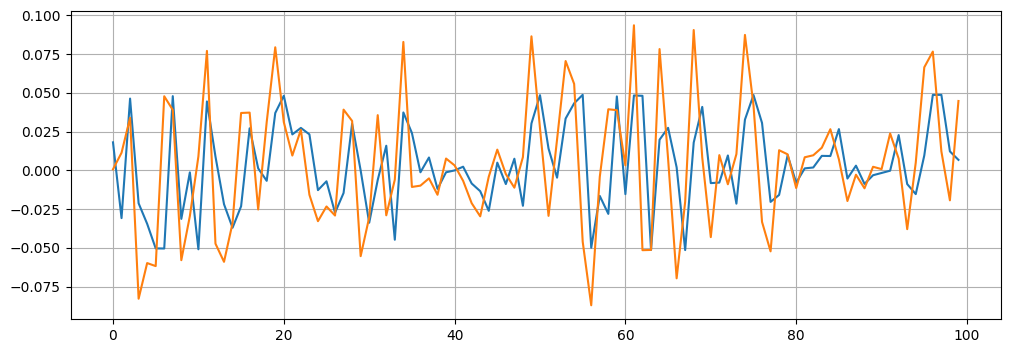

In [35]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(y_test)):
    # persistence
    yhat = X_test[t]
    error = y_test[t] - yhat
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print('predicted=%f, expected=%f' % (yhat, y_test[t]))

rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(12, 4))
plt.plot(y_test[:100])
plt.plot(predictions[:100])
plt.grid()
plt.show()

### **Residuals stats**

In [36]:
# persistence model
predictions = [x for x in X_test]
residuals = [y_test[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

           0
count 345.00
mean    0.00
std     0.04
min    -0.14
25%    -0.02
50%    -0.00
75%     0.03
max     0.11


### **Residuals plots**

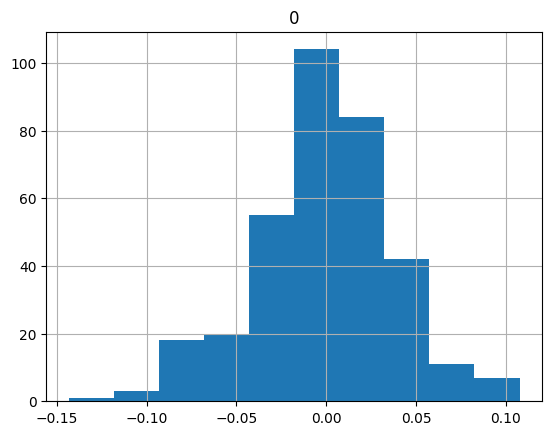

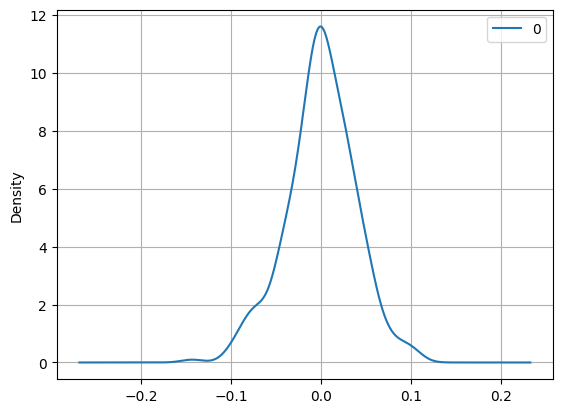

In [37]:
# histogram plot
residuals.hist()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.grid()
plt.show()

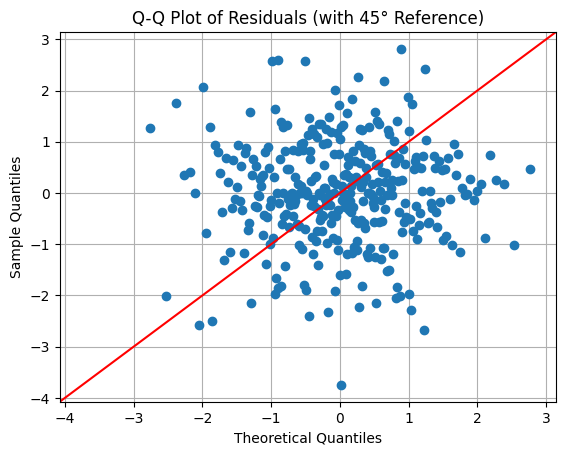

In [38]:
sm.qqplot(residuals, line='45', fit=True, marker='o')
plt.title('Q-Q Plot of Residuals (with 45° Reference)')
plt.grid(True)
plt.show()

## **ACF & PACF on original data**

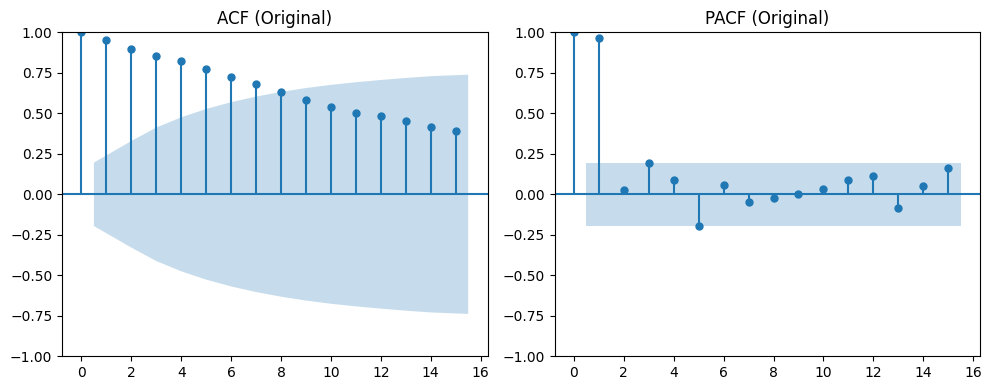

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(data['Close'][:100], lags=15, title='ACF (Original)', ax=ax1)
plot_pacf(data['Close'][:100], lags=15, title='PACF (Original)', method='ols', ax=ax2)
plt.tight_layout()
plt.show()

- ACF shows gradual decay (high correlation at early lags that persists), indicating non-stationarity, trend or unit root is present in the data.
- The PACF has a significant spike only at lag 1, then drops close to zero. Suggests an AR(1) component (autoregressive term of order 1).

No Significant Lags Beyond 1:

No other lags exceed the confidence interval (blue band).

## **ACF and PACF of differenced data**

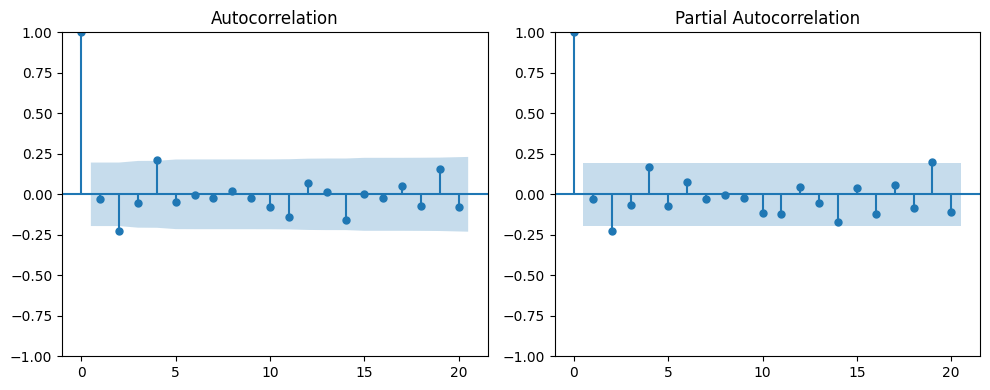

In [40]:
X = np.log(data['Close']).diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(X[:100], lags=20, ax=ax1)
plot_pacf(X[:100], lags=20, ax=ax2, method='ols')
plt.tight_layout()
plt.show()

## **Grid search with AIC/BIC**

In [41]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
for order in pdq:
    try:
        model = ARIMA(data['Close'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f"Best ARIMA{best_order} AIC:{best_aic:.2f}")

Best ARIMA(4, 1, 3) AIC:4244.59


#**ARIMA-GRID Search**

In [42]:
# X = data['Close'].values

# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.80)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out-of-sample error
#     rmse = sqrt(mean_squared_error(test, predictions))
#     return rmse

# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = evaluate_arima_model(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except Exception as e:
#                     print(f'ARIMA{order} failed: {e}')
#                     continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# p_values = [0, 1, 2, 4, 6, 8, 10]
# d_values = range(0, 3)
# q_values = range(0, 3)
# evaluate_models(X, p_values, d_values, q_values)

## **ARIMA (4,1,3)**

In [43]:
X = data['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(4,1,3)).fit()
    yhat = model.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

           0
count 346.00
mean    0.03
std     1.70
min    -4.64
25%    -1.01
50%    -0.16
75%     1.06
max     6.44


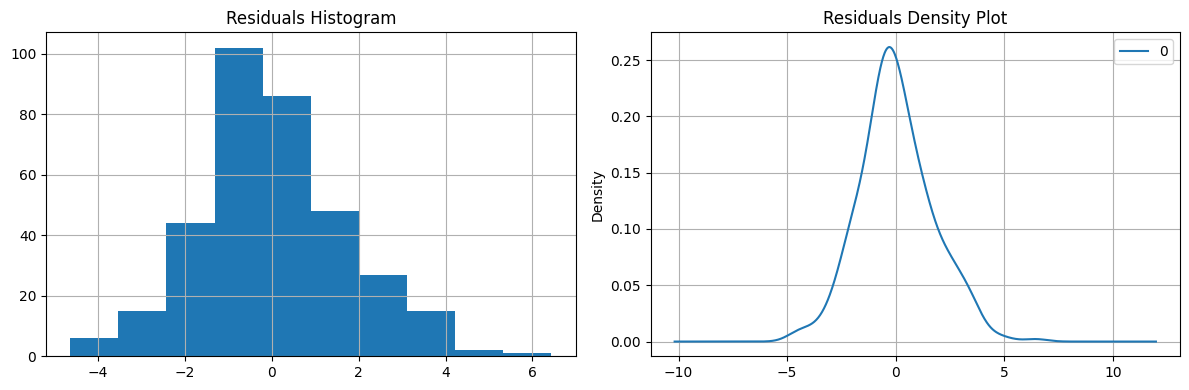

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
residuals.hist(ax=plt.gca())
plt.title('Residuals Histogram')

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title('Residuals Density Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

## **bias-correct predictions using mean value**

RMSE: 1.698
           0
count 346.00
mean   -0.00
std     1.70
min    -4.67
25%    -1.04
50%    -0.19
75%     1.03
max     6.41


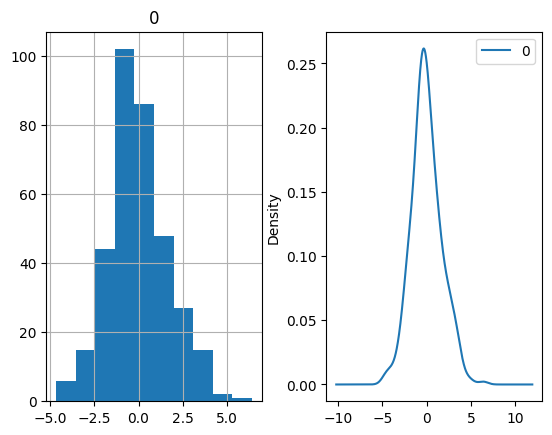

In [45]:
X = data['Close'].values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
bias = 0.03
for i in range(len(test)):
    model = ARIMA(history, order=(4,1,3)).fit()
    yhat = bias + float(model.forecast()[0])
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure()
plt.subplot(121)
residuals.hist(ax=plt.gca())
plt.subplot(122)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [46]:
# # make first prediction
# predictions = list()
# yhat = bias + float(model_fit.forecast()[0])
# predictions.append(yhat)
# history.append(y[0])
# print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# # rolling forecasts
# for i in range(1, len(y)):
#     # predict
#     model = ARIMA(history, order=(4,1,3)).fit()
#     yhat = bias + float(model_fit.forecast()[0])
#     predictions.append(yhat)
#     # observation
#     obs = y[i]
#     history.append(obs)
#     print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# # report performance
# rmse = sqrt(mean_squared_error(y, predictions))
# print('RMSE: %.3f' % rmse)
# plt.plot(y)
# plt.plot(predictions, color='red')
# plt.show()